# Public Library Survey Data - Library similarity

In this notebook, we will attempt to group similar libraries together based on a number of dimensions such as budget, demographics, and engagement.

First we will read the 2022 public library data, 2020 presidential election data, as well as three 2023 datasets from the Census: median houshold income, race, and ethnicity.

In [1]:
import pandas as pd
from helpers import *

lib_df = pd.read_csv("data/PLS_FY22_AE_pud22i.csv", encoding="latin-1")
print(f"Found {lib_df.shape[0]:,} entries from the public library survey")

census_county_df = get_census_data(by="County")
census_zip_df = get_census_data(by="Zipcode")
election_df = get_election_data()

Found 9,248 entries from the public library survey
Found 3,222 entries from the Census median household income dataset by County
Found 3,222 entries from the Census race dataset by County
Found 3,222 entries from the Census ethnicity (Hispanic or Latino) dataset by County
Found 33,772 entries from the Census median household income dataset by Zipcode
Found 33,772 entries from the Census race dataset by Zipcode
Found 33,772 entries from the Census ethnicity (Hispanic or Latino) dataset by Zipcode
Found 72,617 entries in the presidential elections dataset
Found 3155 counties with data for year 2020
Parsing election data...


100%|██████████| 3155/3155 [00:03<00:00, 816.83it/s]


Next we need to add County codes to our library data so we can match it with the Census data

In [2]:
# Read zipcode data to retrieve county codes
zip_df = pd.read_csv("data/us_zip_fips_county.csv", encoding="latin-1")
zip_df = zip_df[["Zip Code", "FIPS Code"]]

# Merge lib data with zipcode data to get count IDs
lib_df["ZIP"] = lib_df.apply(
    lambda row: str(parse_int(row["ZIP"], 0)).zfill(5), axis=1
)
zip_df["ZIP"] = zip_df.apply(
    lambda row: str(parse_int(row["Zip Code"], 0)).zfill(5), axis=1
)
lib_df = pd.merge(lib_df, zip_df, on="ZIP", how="left")

Next we will merge the four datasets on county (FIPS) code for cities, and zipcode for all others

In [3]:
lib_df = merge_data(
    lib_df,
    census_county_df,
    census_zip_df,
    election_df,
)
print(f"Found {lib_df.shape[0]:,} entries after merging")

Found 9,248 entries after merging


Next let's make sure household income is an integer

In [4]:
# Parse income
lib_df["MEDIAN_INCOME"] = lib_df.apply(
    lambda row: parse_int(row["B19013_001E"]), axis=1
)
print(f"The median median houshold income is ${lib_df['MEDIAN_INCOME'].median():,}")

The median median houshold income is $70,714.0


Next let's create one column that represents percentage of population that are people of color or Hispanic/Latino.

In [5]:
lib_df = calculate_percent_pos(lib_df)
print(f"The median percent White per library is {lib_df['PERC_WHITE'].median():,}%")
print(f"The median percent Black per library is {lib_df['PERC_BLACK'].median():,}%")
print(f"The median percent Hispanic/Latino per library is {lib_df['PERC_HISPANIC'].median():,}%")
print(f"The median percent Indigenous per library is {lib_df['PERC_INDIGENOUS'].median():,}%")
print(f"The median percent Asian/Pacific Islander per library is {lib_df['PERC_API'].median():,}%")

The median percent White per library is 93.94%
The median percent Black per library is 1.24%
The median percent Hispanic/Latino per library is 4.35%
The median percent Indigenous per library is 0.16%
The median percent Asian/Pacific Islander per library is 0.73%


Next let's make sure operating revenue are all valid numbers

In [6]:
# Parse income
lib_df["TOTINCM"] = lib_df.apply(
    lambda row: parse_int(row["TOTINCM"]), axis=1
)
print(f"The median operating revenue is ${lib_df['TOTINCM'].median():,}")

lib_df.columns[lib_df.isna().any()].tolist()

The median operating revenue is $283,943.0


['Zip Code',
 'FIPS Code',
 'county_fips',
 'demvotes',
 'repvotes',
 'totalvotes',
 'vote_points']

Next let's try to reduce these fields to 2 dimensions using [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [8]:
from sklearn.preprocessing import StandardScaler
import umap

reducer = umap.UMAP()
columns_to_reduce = [
    "MEDIAN_INCOME",
    "TOTINCM",
    "vote_points",
    "PERC_WHITE",
    "PERC_BLACK",
    "PERC_INDIGENOUS",
    "PERC_API",
    "PERC_HISPANIC"
]

# Get only the relevant data we need
lib_data = lib_df[columns_to_reduce].fillna(0).values
scaled_data = StandardScaler().fit_transform(lib_data)
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(9248, 2)

And plot the results on a scatter chart

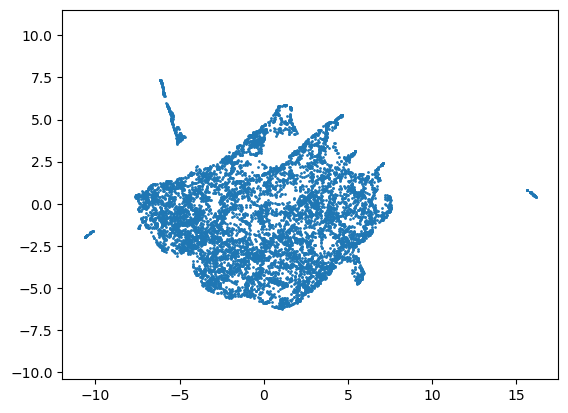

In [9]:
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

Now let's add the embeddings back to the original data, select one library (the Detroit Public Library), and display the most similar libraries based on the embeddings

In [10]:
import math

lib_df["EMBEDDING"] = lib_df.apply(lambda row: embedding[row.name], axis=1)
lib = find_where(lib_df, "LIBNAME", "DETROIT PUBLIC LIBRARY")
lib_df["DISTANCE"] = lib_df.apply(lambda row: math.dist(lib["EMBEDDING"], row["EMBEDDING"]), axis=1)
sorted_df = lib_df.sort_values("DISTANCE")
columns_to_display = ["LIBNAME", "CITY", "STABR"] + columns_to_reduce + ["DISTANCE"]
sorted_df[columns_to_display].head(20)


1


,LIBNAME,CITY,STABR,MEDIAN_INCOME,TOTINCM,vote_points,PERC_WHITE,PERC_BLACK,PERC_INDIGENOUS,PERC_API,PERC_HISPANIC,DISTANCE
3870,DETROIT PUBLIC LIBRARY,DETROIT,MI,59521,33348455,-38.12,53.27,39.69,0.35,3.74,6.71,0.000000
301,CENTRAL ARKANSAS LIBRARY SYSTEM,LITTLE ROCK,AR,60385,27202740,-22.51,54.25,39.37,0.35,2.35,8.20,0.080446
4357,CITY OF ST. LOUIS MUNICIPAL LIBRARY DISTRICT,ST. LOUIS,MO,55279,32052653,-66.20,48.57,45.80,0.26,3.67,5.12,0.202047
7493,RICHLAND COUNTY PUBLIC LIBRARY,COLUMBIA,SC,61699,31805597,-38.31,43.61,50.00,0.23,3.17,6.29,0.244277
1092,FULTON COUNTY LIBRARY SYSTEM,ATLANTA,GA,91490,27860053,-46.49,42.08,46.11,0.27,8.15,8.06,0.252729
8926,MILWAUKEE PUBLIC LIBRARY,MILWAUKEE,WI,62118,29925175,-39.85,58.66,29.17,0.69,5.27,16.64,0.263741
3522,ENOCH PRATT FREE LIBRARY,BALTIMORE,MD,59623,37385899,-76.60,28.91,63.35,0.38,2.71,7.87,0.403835
7722,MEMPHIS PUBLIC LIBRARY AND INFORMATION CENTER,MEMPHIS (S),TN,62337,24207690,-30.44,36.76,55.46,0.41,3.11,8.49,0.433855
8434,FAIRFAX COUNTY PUBLIC LIBRARY,FAIRFAX,VA,-1,42595953,-41.84,0.00,0.00,0.00,0.00,0.00,0.444606
7723,NASHVILLE PUBLIC LIBRARY,NASHVILLE,TN,75664,38746941,-32.13,62.78,27.73,0.37,3.79,13.59,0.453159


Finally, let's calculate the distances for each public library and output the data.

In [11]:
import json
from tqdm import tqdm

similar_libraries = []
embeddings = lib_df["EMBEDDING"].to_list()
embeddings = [{"index": i, "embedding": embedding} for i, embedding in enumerate(embeddings)]
for embedding in tqdm(embeddings):
    without_self = [row for row in embeddings if row["index"] != embedding["index"]]
    by_similarity = sorted(without_self, key=lambda row: math.dist(row["embedding"], embedding["embedding"]))
    indices = [row["index"] for row in by_similarity[:20]]
    similar_libraries.append(indices)

output_file = "public/data/2022-library-data-similarity.json"
with open(output_file, "w") as f:
    json.dump(similar_libraries, f)
print(f"Created similarity data file at {output_file}.")

100%|██████████| 9248/9248 [03:03<00:00, 50.31it/s]

Created similarity data file at public/data/2022-library-data-similarity.json.


This is now a feature in the [user interface](https://beefoo.github.io/public-library-survey/). Click on the "Similar libraries" tab after you select any library.